# Identification of Potential Drug Targets of Inflammatory Bowel Disease

*Please note: This notebook uses open access data*  

#### Fan Wang
#### July 31 2022

Systematic MR of molecular phenotypes such as proteins and expression of transcript levels offer enormous potential to prioritise drug targets for further investigation. However, many genes and gene products are not easily druggable, so some potentially important causal genes may not offer an obvious route to intervention.

A parallel problem is that current GWAS of molecular phenotypes have limited sample sizes and limited protein coverages. A potential way to address both these problems is to use protein-protein interaction (PPI) information to identify druggable targets which are linked to a non-druggable, but robustly causal target. Their relationship to the causal target increases our confidence in their potential causal role even if the initial evidence of effect is below our multiple-testing threshold.

This notebook demonstrates an approach to query data in [EpiGraphDB](https://api.epigraphdb.org/) to prioritize potential alternative drug targets in the same PPI network for Inflammatory Bowel Disease (IBD), as follows:

* For an existing drug target of interests, we use PPI networks to search for its directly interacting genes that are evidenced to be druggable.
* We then examine the causal evidence of these candidate genes on the disease.
* We also examine the literature evidence of these candidate genes on the disease.
* Then we query the metadata including meta nodes and meta edges and the overall schema.

In [1]:
import json
from pprint import pprint
from pprint import pformat
import matplotlib
import matplotlib.pyplot as plt

get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'svg'")
import networkx as nx
import requests
import pandas as pd

First, we will ping the API to check our connection. Here we use the .get() method to send a GET request to the `/ping` endpoint of the API.

In [2]:
API_URL = "https://api.epigraphdb.org"
endpoint = "/ping"
response_object = requests.get(API_URL + endpoint)
GENE_NAME = "IL23R"
OUTCOME_TRAIT = "Inflammatory bowel disease"

# Check that the ping was sucessful
try:
    response_object.raise_for_status()
    print("If this line gets printed, ping was sucessful.")
except requests.exceptions.HTTPError as err:
    print(err)

If this line gets printed, ping was sucessful.


### 1. Using PPI networks for alternative drug targets search
The assumption here is that the most likely alternative targets are either directly interacting with IL23R or somewhere in the PPI network. In this example, we consider only genes that were found to interact with *IL23R* via direct protein-protein interactions, and require that those interacting proteins should also be druggable.

The thousands of genes are classified with regard to their druggability by Finan et al. 2017, where the Tier 1 category refers to approved drugs or those in clinical testing while for other tier categories the druggability confidence drops in order Tier 2 and then Tier 3.

In [3]:
def get_drug_targets_ppi(gene_name):
    endpoint = "/gene/druggability/ppi"
    url = f"{API_URL}{endpoint}"
    params = {"gene_name": gene_name}
    r = requests.get(url, params=params)
    r.raise_for_status()
    df = pd.json_normalize(r.json()["results"])
    return df


GENE_NAME = "IL23R"
OUTCOME_TRAIT = "Inflammatory bowel disease"
ppi_df = get_drug_targets_ppi(gene_name=GENE_NAME)
ppi_df

,g1.name,p1.uniprot_id,p2.uniprot_id,g2.name,g2.druggability_tier
0,IL23R,Q5VWK5,P04141,CSF2,Tier 1
1,IL23R,Q5VWK5,P01562,IFNA1,Tier 1
2,IL23R,Q5VWK5,P01579,IFNG,Tier 1
3,IL23R,Q5VWK5,P22301,IL10,Tier 1
4,IL23R,Q5VWK5,P29460,IL12B,Tier 1
5,IL23R,Q5VWK5,P42701,IL12RB1,Tier 1
6,IL23R,Q5VWK5,P35225,IL13,Tier 1
7,IL23R,Q5VWK5,P40933,IL15,Tier 1
8,IL23R,Q5VWK5,Q16552,IL17A,Tier 1
9,IL23R,Q5VWK5,Q96PD4,IL17F,Tier 1


For further analysis we select the gene of interest (*IL23R*) as well as its interacting genes with Tier 1 druggability.

In [4]:
def get_gene_list(ppi_df, include_primary_gene: bool = True):
    if include_primary_gene:
        gene_list = list(ppi_df["g1.name"].drop_duplicates()) + list(
            ppi_df.query("`g2.druggability_tier` == 'Tier 1'")["g2.name"]
        )
    else:
        gene_list = list(ppi_df.query("`g2.druggability_tier` == 'Tier 1'")["g2.name"])
    return gene_list


gene_list = get_gene_list(ppi_df)
gene_list

['IL23R',
 'CSF2',
 'IFNA1',
 'IFNG',
 'IL10',
 'IL12B',
 'IL12RB1',
 'IL13',
 'IL15',
 'IL17A',
 'IL17F',
 'IL2',
 'IL22',
 'IL23A',
 'IL4',
 'IL5',
 'IL6',
 'IL9',
 'JAK1',
 'JAK2',
 'NFKB1',
 'PIK3CA',
 'RORC',
 'STAT3',
 'TSLP',
 'TYK2']

### 2. Looking for literature evidence
EpiGraphDB facilitates fast processing of this information by allowing access to a host of literature-mined relationships that have been structured into semantic triples. These take the general form (subject, predicate, object) and have been generated using contemporary natural language processing techniques applied to a massive amount of published biomedical research papers by [SemMedDB](https://lhncbc.nlm.nih.gov/ii/tools/SemRep_SemMedDB_SKR.html). In the following section we will query the API for the literature relationship between a given gene, *IL23R* (several studies confirmed IL23R associations in independent cohorts of patients with Crohn's disease or ulcerative colitis) and an outcome trait, Inflammatory bowel disease.

In [5]:
def extract_literature(outcome_trait, gene_list):
    def per_gene(gene_name):
        endpoint = "/gene/literature"
        url = f"{API_URL}{endpoint}"
        params = {"gene_name": gene_name, "object_name": outcome_trait.lower()}
        r = requests.get(url, params=params)
        try:
            r.raise_for_status()
            res_df = pd.json_normalize(r.json()["results"])
            if len(res_df) > 0:
                res_df = res_df.assign(
                    literature_count=lambda df: df["pubmed_id"].apply(lambda x: len(x))
                )
            return res_df
        except:
            return None

    res_df = pd.concat(
        [per_gene(gene_name=gene_name) for gene_name in gene_list]
    ).reset_index(drop=True)
    return res_df


literature_df = extract_literature(outcome_trait=OUTCOME_TRAIT, gene_list=gene_list)
literature_df

,pubmed_id,gene.name,lt.id,lt.name,lt.type,st.predicate,literature_count
0,[23131344],IL23R,C0021390,Inflammatory Bowel Diseases,[dsyn],PREDISPOSES,1
1,"[21155887, 17484863]",IL23R,C0021390,Inflammatory Bowel Diseases,[dsyn],NEG_ASSOCIATED_WITH,2
2,[31728561],IL23R,C0021390,Inflammatory Bowel Diseases,[dsyn],CAUSES,1
3,"[21155887, 18383521, 18383363, 25159710, 18341...",IL23R,C0021390,Inflammatory Bowel Diseases,[dsyn],ASSOCIATED_WITH,21
4,[27852544],IL23R,C0021390,Inflammatory Bowel Diseases,[dsyn],AFFECTS,1
5,"[21557945, 19030026]",CSF2,C0021390,Inflammatory Bowel Diseases,[dsyn],ASSOCIATED_WITH,2
6,[17206685],CSF2,C0021390,Inflammatory Bowel Diseases,[dsyn],AFFECTS,1
7,[23891915],IFNA1,C0021390,Inflammatory Bowel Diseases,[dsyn],TREATS,1
8,[24975266],IFNA1,C0021390,Inflammatory Bowel Diseases,[dsyn],PREVENTS,1
9,"[20951137, 28174758, 9836081]",IFNA1,C0021390,Inflammatory Bowel Diseases,[dsyn],ASSOCIATED_WITH,3


### 3. Using Mendelian randomization results for causal effect estimation
The next step is to find out whether any of these genes have a comparable and statistically plausable effect on IBD.

In [6]:
def extract_mr(outcome_trait, gene_list, qtl_type):
    endpoint = "/xqtl/single-snp-mr"
    url = f"{API_URL}{endpoint}"

    def per_gene(gene_name):
        params = {
            "exposure_gene": gene_name,
            "outcome_trait": outcome_trait,
            "qtl_type": qtl_type,
            "pval_threshold": 1e-5,
        }
        r = requests.get(url, params=params)
        try:
            r.raise_for_status()
            df = pd.json_normalize(r.json()["results"])
            return df
        except:
            return None

    res_df = pd.concat(
        [per_gene(gene_name=gene_name) for gene_name in gene_list]
    ).reset_index(drop=True)
    return res_df


# Search for both pqtl and eqtl
xqtl_df = pd.concat(
    [
        extract_mr(
            outcome_trait=OUTCOME_TRAIT, gene_list=gene_list, qtl_type=qtl_type
        ).assign(qtl_type=qtl_type)
        for qtl_type in ["pQTL", "eQTL"]
    ]
).reset_index(drop=True)
xqtl_df

,gene.ensembl_id,gene.name,gwas.id,gwas.trait,r.beta,r.se,r.p,r.rsid,qtl_type
0,ENSG00000162594,IL23R,ieu-a-294,Inflammatory bowel disease,1.500821,0.054592,2.212578e-166,rs11581607,pQTL
1,ENSG00000113302,IL12B,ieu-a-294,Inflammatory bowel disease,0.417605,0.034490,9.590000e-34,rs4921484,pQTL
2,ENSG00000162594,IL23R,ieu-a-294,Inflammatory bowel disease,0.886712,0.064420,4.165652e-43,rs2064689,eQTL
3,ENSG00000164136,IL15,ieu-a-294,Inflammatory bowel disease,-1.421625,0.197131,5.530616e-13,rs75301646,eQTL
4,ENSG00000113520,IL4,ieu-a-294,Inflammatory bowel disease,0.459848,0.084050,4.471537e-08,rs2070874,eQTL
5,ENSG00000096968,JAK2,ieu-a-294,Inflammatory bowel disease,-1.896710,0.203808,1.322967e-20,rs4788084,eQTL
6,ENSG00000109320,NFKB1,ieu-a-294,Inflammatory bowel disease,0.973556,0.173893,2.160849e-08,rs4766578,eQTL
7,ENSG00000143365,RORC,ieu-a-294,Inflammatory bowel disease,-0.994991,0.116343,1.207271e-17,rs4845604,eQTL
8,ENSG00000168610,STAT3,ieu-a-294,Inflammatory bowel disease,0.597473,0.075700,2.958269e-15,rs1053004,eQTL


### 4. Query metadata

Here we query for the metadata information using the endpoint `GET /meta/schema`, which will be used for downstream processing.

In [7]:
endpoint = "/meta/schema"
params = {"graphviz": False, "plot": False}
r = requests.get(f"{API_URL}{endpoint}", params=params)
r.raise_for_status()
metadata = r.json()

# Preview of metadata information
keys = metadata.keys()
print(pformat(keys), "\n")
for key in list(keys):
    print(f"# {key}:")
    print(pformat(metadata[key])[:1000], "\n")

dict_keys(['nodes', 'edges', 'connections']) 

# nodes:
{'Disease': {'count': 38960,
             'properties': {'_id': {'indexed': True,
                                    'type': 'STRING',
                                    'unique': False},
                            '_name': {'indexed': True,
                                      'type': 'STRING',
                                      'unique': False},
                            '_source': {'indexed': False,
                                        'type': 'LIST',
                                        'unique': False},
                            'definition': {'indexed': False,
                                           'type': 'STRING',
                                           'unique': False},
                            'doid': {'indexed': True,
                                     'type': 'LIST',
                                     'unique': False},
                            'efo': {'indexed': False,
                

We can extract the specific meta node information as a pandas dataframe from the metadata.

In [8]:
meta_node_df = pd.DataFrame.from_dict(metadata["nodes"], orient="index")

(
    meta_node_df.sort_index().assign(
        count=lambda df: df["count"].apply(lambda x: f"{x:,}")
    )
)

,count,properties
Disease,"38,960","{'_name': {'type': 'STRING', 'indexed': True, ..."
Drug,"2,697","{'molecule_type': {'type': 'STRING', 'indexed'..."
Efo,"25,390","{'_name': {'type': 'STRING', 'indexed': True, ..."
Gene,"57,737","{'druggability_tier': {'type': 'STRING', 'inde..."
Gwas,"34,494","{'note': {'type': 'STRING', 'indexed': False, ..."
Literature,"3,995,672","{'issn': {'type': 'STRING', 'indexed': False, ..."
LiteratureTerm,"108,905","{'_name': {'type': 'STRING', 'indexed': True, ..."
LiteratureTriple,"5,609,945","{'subject_id': {'type': 'STRING', 'indexed': T..."
Pathway,"2,441","{'_name': {'type': 'STRING', 'indexed': True, ..."
Protein,"20,280","{'name': {'type': 'STRING', 'indexed': True, '..."


We can also extract the meta relationship (edge) information, and the connections.

In [9]:
meta_rel_df = pd.DataFrame.from_dict(metadata["edges"], orient="index").merge(
    pd.DataFrame.from_dict(
        {_["rel"]: _ for _ in metadata["connections"]}, orient="index"
    )[["from_node", "to_node"]],
    left_index=True,
    right_index=True,
)

(
    meta_rel_df.sort_values(by=["from_node", "to_node"]).assign(
        count=lambda df: df["count"].apply(lambda x: f"{x:,}")
    )
)

,count,properties,from_node,to_node
MONDO_MAP_EFO,"2,819","{'_source': {'array': False, 'type': 'STRING'}}",Disease,Efo
MONDO_MAP_UMLS,"8,247","{'_source': {'array': False, 'type': 'STRING'}}",Disease,LiteratureTerm
OPENTARGETS_DRUG_TO_DISEASE,"2,461","{'_source': {'array': True, 'type': 'LIST'}}",Drug,Disease
CPIC,375,{'pharmgkb_level_of_evidence': {'array': False...,Drug,Gene
OPENTARGETS_DRUG_TO_TARGET,"6,534","{'phase': {'array': False, 'type': 'STRING'}, ...",Drug,Gene
EFO_CHILD_OF,"43,132","{'_source': {'array': True, 'type': 'LIST'}}",Efo,Efo
GENE_TO_DISEASE,"5,763","{'last_updated': {'array': False, 'type': 'STR...",Gene,Disease
XQTL_MULTI_SNP_MR,"3,015,233","{'p': {'array': False, 'type': 'FLOAT'}, 'se':...",Gene,Gwas
XQTL_SINGLE_SNP_MR_GENE_GWAS,"8,449,779","{'p': {'array': False, 'type': 'FLOAT'}, 'se':...",Gene,Gwas
GENE_TO_PROTEIN,"19,142","{'_source': {'array': True, 'type': 'LIST'}}",Gene,Protein


We can generate a network diagram of the graph db schema using `networkx`.

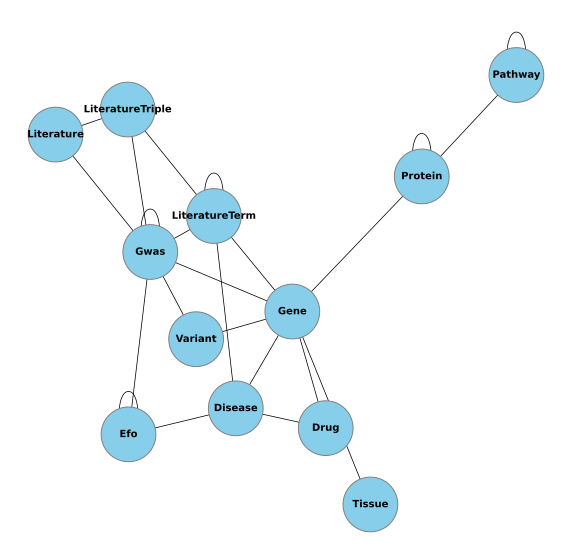

In [10]:
graph = nx.from_pandas_edgelist(meta_rel_df, source="from_node", target="to_node")
cmap = matplotlib.colors.ListedColormap(["dodgerblue", "lightgray", "darkorange"])
meta_rel_df["from_node"] = pd.Categorical(meta_rel_df["from_node"])
f = plt.figure(figsize=(10, 10))
f.tight_layout()
plt.subplot(1, 1, 1)
nx.draw(
    G=graph,
    with_labels=True,
    node_size=3000,
    edgecolors="gray",
    node_color="skyblue",
    font_size=10,
    font_weight="bold",
    width=0.75,
)

### Reference

* Duerr RH, Taylor KD, Brant SR, Rioux JD, Silverberg MS, Daly MJ, Steinhart AH, Abraham C, Regueiro M, Griffiths A, others. 2006. A genome-wide association study identifies IL23R as an inflammatory bowel disease gene. Science 314:1461–1463.

* Finan C, Gaulton A, Kruger FA, Lumbers RT, Shah T, Engmann J, Galver L, Kelley R, Karlsson A, Santos R, others. 2017. The druggable genome and support for target identification and validation in drug development. Science translational medicine 9:eaag1166.

* Momozawa Y, Mni M, Nakamura K, Coppieters W, Almer S, Amininejad L, Cleynen I, Colombel J-F, De Rijk P, Dewit O, others. 2011. Resequencing of positional candidates identifies low frequency IL23R coding variants protecting against inflammatory bowel disease. Nature genetics 43:43–47.

* Zheng J, Brumpton BM, Bronson PG, Liu Y, Haycock P, Elsworth B, Haberland V, Baird D, Walker V, Robinson JW, John S, Prins B, Runz H, Nelson MR, Hurle M, Hemani G, Asvold BO, Butterworth A, Smith GD, Scott RA, Gaunt TR. 2019. Systematic Mendelian randomization and colocalization analyses of the plasma proteome and blood transcriptome to prioritize drug targets for complex disease.